### Gadi path set-up

In [1]:
import os
import pathlib

nci_user_name = "abc123"   ### change this to your NCI user name
work_path = pathlib.Path("/g/data/nm05/workspace/").joinpath(nci_user_name)
source_folder = pathlib.Path("/g/data/nm05/workshop_data/time_series/synthetic")

### Comment these three lines below, which are here for pre-workshop testing
work_path = pathlib.Path().home().joinpath("aurora_test_folder")
work_path.mkdir(parents=True, exist_ok=True)

os.chdir(work_path)
target_folder = work_path

## Process CAS04 Data with Aurora

CAS04 was a trial station selected because it was first in alphabetical order from a collection of "recent" stations.  This station was used as a proof of concept to show that aurora could reproduce EMTF results for USArray data.

The steps are similar to the synthetic data workbook, but in this case we have a larger data set with more interesting things happening.

The data are already created and available on the IRIS ftp website:

http://ftp.iris.washington.edu/pub/dropoff/buffer/MT_test_data/

but they can also be generated using aurora/tests/CAS04/01_make_cas04_mth5.py

This notebook starts from an existing h5 file.

1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

In [2]:
# Uncomment the following line to make plots interactive.
# %matplotlib widget

### Here are the modules we will need to import 

In [3]:
import pathlib
import warnings

import pandas as pd

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.sandbox.mth5_helpers import build_request_df
from aurora.test_utils.synthetic.make_mth5_from_asc import create_test12rr_h5
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.clients import FDSN
from mth5.utils.helpers import initialize_mth5

warnings.filterwarnings('ignore')

# 1. Build MTH5 file
(if it does not exist locally, it can also be built by running `aurora/tests/cas04/01_make_cas04_mth5.py`)

#### Define data set in terms of network, stations, channels and time bounds

In [4]:
NETWORK_ID = "8P"
STATION_IDS = [
    "CAS04",
    "CAV07",
    "NVR11",
    "REV06",
]
CHANNELS = [
    "LQE",
    "LQN",
    "LFE",
    "LFN",
    "LFZ",
]
START = "2020-06-02T19:00:00"
END = "2020-07-13T19:00:00"

#### Make merged request dataframe

In [5]:
df_list = []
for station_id in STATION_IDS:
    df = build_request_df(
        NETWORK_ID, station_id, channels=CHANNELS, start=START, end=END
    )
    df_list.append(df)
request_df = pd.concat(df_list)
request_df.reset_index(inplace=True, drop=True)
request_df

request_list: [['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']]
request_list: [['8P', 'CAV07', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAV07', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAV07', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAV07', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'CAV07', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']]
request_list: [['8P', 'NVR11', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'NVR11', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00'], ['8P', 'NVR11', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00

,network,station,location,channel,start,end
0,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,CAV07,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,CAV07,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,CAV07,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,CAV07,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,CAV07,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00


#### Define mth5 file (make if needed)

In [6]:
mth5_version = "0.2.0"
fdsn_object = FDSN(mth5_version=mth5_version)
fdsn_object.client = "IRIS"

expected_mth5_path = work_path.joinpath(fdsn_object.make_filename(request_df))

if expected_mth5_path.exists():
    print(f"Already have data for {expected_mth5_path.name}")
    mth5_path = expected_mth5_path
else:
    mth5_path = fdsn_object.make_mth5_from_fdsn_client(
        request_df, interact=False, path=work_path
    )

Already have data for 8P_CAS04_CAV07_NVR11_REV06.h5


In [7]:
print(f"MTH5 file {mth5_path.name} stored at {mth5_path}")

MTH5 file 8P_CAS04_CAV07_NVR11_REV06.h5 stored at /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5


In [8]:
m = initialize_mth5(mth5_path)

In [9]:
channel_summary_df = m.channel_summary.to_dataframe()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(channel_summary_df)
    #channel_summary_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.38750,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.38750,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.38750,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.38750,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.38750,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.38750,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.38750,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.38750,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.38750,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.38750,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want

In [10]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

2023-11-15T15:35:01.388820-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5


,survey,station_id,run_id,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00
4,CONUS South,CAV07,a,2020-06-09 23:21:35+00:00,2020-06-09 23:54:43+00:00
5,CONUS South,CAV07,b,2020-06-10 03:20:38+00:00,2020-06-10 03:36:12+00:00
6,CONUS South,CAV07,c,2020-06-10 03:50:04+00:00,2020-06-23 17:35:37+00:00
7,CONUS South,CAV07,d,2020-06-23 18:38:51+00:00,2020-07-06 16:31:12+00:00
8,CONUS South,NVR11,a,2020-06-12 21:10:38+00:00,2020-06-12 21:59:40+00:00
9,CONUS South,NVR11,b,2020-06-12 22:13:24+00:00,2020-06-26 19:35:21+00:00


Here we can see that the run summary is much more interesting than the synthetic example.  We have four stations and each station has mulitple runs.


### Select Stations to Process

Process CAS04, with respect to CAV07

## Define a Kernel Dataset


In [11]:
local_station_id = "CAS04"
remote_station_id = "CAV07" 

In [12]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, local_station_id, remote_station_id)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,CONUS South,CAS04,b,2020-06-09 23:21:35+00:00,2020-06-09 23:54:43+00:00,1988.0
1,CONUS South,CAV07,a,2020-06-09 23:21:35+00:00,2020-06-09 23:54:43+00:00,1988.0
2,CONUS South,CAS04,b,2020-06-10 03:20:38+00:00,2020-06-10 03:36:12+00:00,934.0
3,CONUS South,CAV07,b,2020-06-10 03:20:38+00:00,2020-06-10 03:36:12+00:00,934.0
4,CONUS South,CAS04,b,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,223339.0
5,CONUS South,CAV07,c,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,223339.0
6,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,947000.0
7,CONUS South,CAV07,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,947000.0
8,CONUS South,CAS04,c,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,687248.0
9,CONUS South,CAV07,d,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,687248.0


THere are som short runs here, see the "duration" column in the full df:

In [13]:
kernel_dataset.df


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,CONUS South,CAS04,b,2020-06-09 23:21:35+00:00,2020-06-09 23:54:43+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,False,1988.0,False
1,CONUS South,CAV07,a,2020-06-09 23:21:35+00:00,2020-06-09 23:54:43+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,True,1988.0,False
2,CONUS South,CAS04,b,2020-06-10 03:20:38+00:00,2020-06-10 03:36:12+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,False,934.0,False
3,CONUS South,CAV07,b,2020-06-10 03:20:38+00:00,2020-06-10 03:36:12+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,True,934.0,False
4,CONUS South,CAS04,b,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,False,223339.0,False
5,CONUS South,CAV07,c,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,True,223339.0,False
6,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,False,947000.0,False
7,CONUS South,CAV07,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,True,947000.0,False
8,CONUS South,CAS04,c,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,False,687248.0,False
9,CONUS South,CAV07,d,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/aurora_test_folder/8P_CAS04_CAV...,True,687248.0,False


So we can drop some of these rows

In [14]:
kernel_dataset.drop_runs_shorter_than(10000)
    

In [15]:
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,CONUS South,CAS04,b,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,223339.0
1,CONUS South,CAV07,c,2020-06-10 03:50:04+00:00,2020-06-12 17:52:23+00:00,223339.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,947000.0
3,CONUS South,CAV07,c,2020-06-12 18:32:17+00:00,2020-06-23 17:35:37+00:00,947000.0
4,CONUS South,CAS04,c,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,687248.0
5,CONUS South,CAV07,d,2020-06-23 18:38:51+00:00,2020-07-01 17:32:59+00:00,687248.0
6,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-06 16:31:12+00:00,420857.0
7,CONUS South,CAV07,d,2020-07-01 19:36:55+00:00,2020-07-06 16:31:12+00:00,420857.0


## Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config is then told about the stations via the kernel dataset.

**When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [16]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

2023-11-15T15:35:01.501627-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [17]:
for decimation in config.decimations:
    decimation.window.type = "hamming"

## Call process_mth5

2023-11-15T15:35:01.580861-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
         survey station_id run_id  valid  remote  duration     fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   CONUS South      CAS04      b   True   False  223339.0  False         0         1.0     1.000000            128.0                 128     223339.0            2326.0
1   CONUS South      CAS04      b   True   False  223339.0  False         1         4.0     0.250000            512.0                 128      55834.0             581.0
2   CONUS South      CAS04      b   True   False  223339.0  False         2         4.0     0.062500           2048.0                 128      13958.0             145.0
3   CONUS South      CAS04      b   True   False  223339.0  False         3         4.0     0.015625           8192.0                 128       3489.0              36.0
4   CONUS Sout

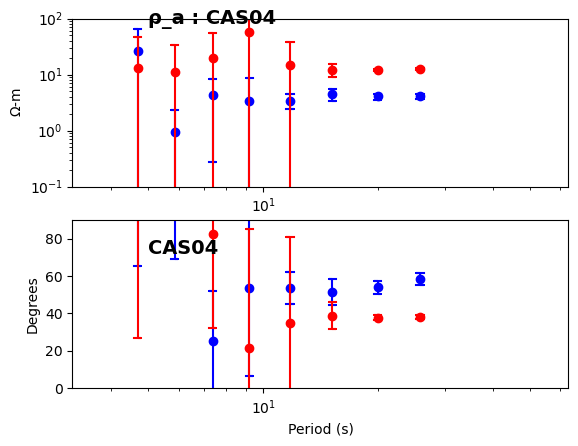

DECIMATION LEVEL 1
2023-11-15T15:35:21.010686-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
2023-11-15T15:35:21.484433-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:21.832715-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:22.280058-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:22.714147-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:23.115335-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:23.5331

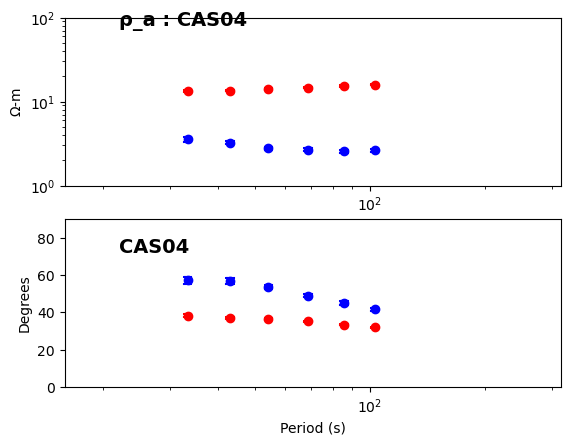

DECIMATION LEVEL 2
2023-11-15T15:35:26.034858-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
2023-11-15T15:35:26.361201-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:26.688987-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:27.048130-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:27.396702-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:27.732849-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:28.0724

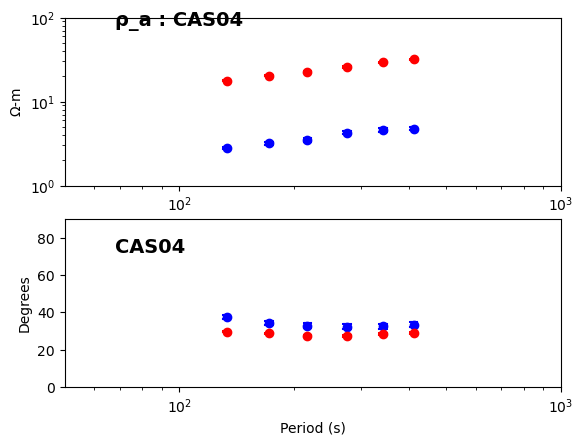

DECIMATION LEVEL 3
2023-11-15T15:35:30.031212-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
2023-11-15T15:35:30.305313-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:30.581699-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:30.910697-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:31.244591-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:31.573754-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:31.9113

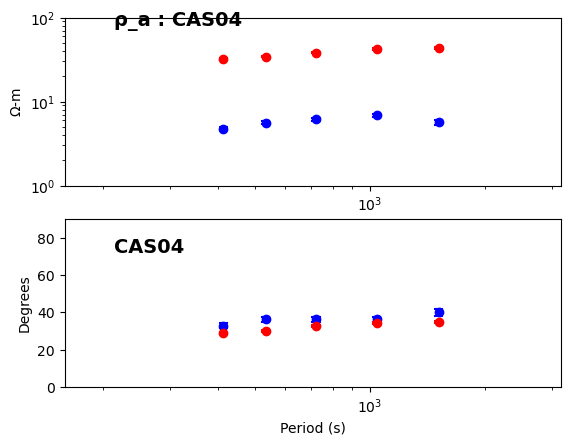

2023-11-15T15:35:33.842767-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5
2023-11-15T15:35:34.003295-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5


In [18]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [19]:
xml_file_base = f"{local_station_id}_RR{remote_station_id}.xml"
tf_cls.write(fn=xml_file_base, file_type="emtfxml")


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

### The Default Processing Configuration is "tuned"

We can modify some of the processing parameters.  Here is an example that shows a more naive processing configuration can give less trustworthy results.

In [20]:
for decimation in config.decimations:
    decimation.prewhitening_type =  ""
    decimation.window.type = "boxcar"
    decimation.extra_pre_fft_detrend_type = None
    

2023-11-15T15:35:34.241359-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
         survey station_id run_id  valid  remote  duration     fc                                     mth5_obj  stft            run_reference dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   CONUS South      CAS04      b   True   False  223339.0  False  HDF5 file is closed and cannot be accessed.  None  <HDF5 object reference>         0         1.0     1.000000            128.0                 128     223339.0            2326.0
1   CONUS South      CAS04      b   True   False  223339.0  False  HDF5 file is closed and cannot be accessed.  None  <HDF5 object reference>         1         4.0     0.250000            512.0                 128      55834.0             581.0
2   CONUS South      CAS04      b   True   False  223339.0  False  HDF5 file is closed and cannot be accessed.  None  <HDF5 

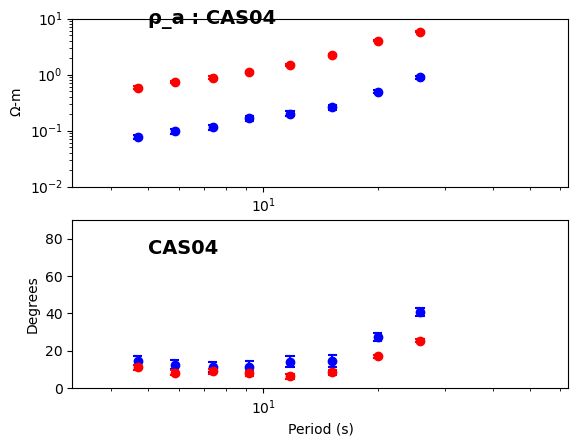

DECIMATION LEVEL 1
2023-11-15T15:35:51.102967-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
2023-11-15T15:35:51.492658-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:51.937929-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:52.459069-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:52.894273-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:53.285557-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:53.6847

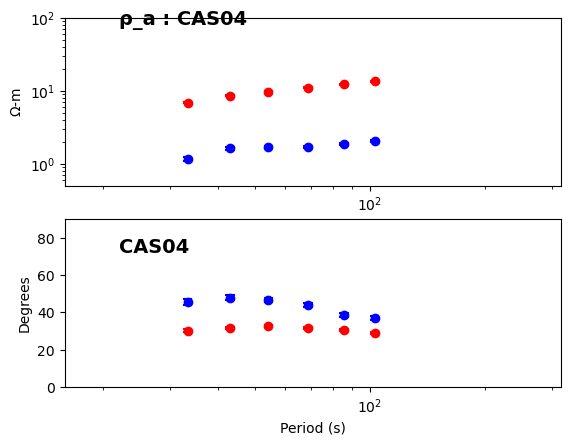

DECIMATION LEVEL 2
2023-11-15T15:35:56.198520-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
2023-11-15T15:35:56.514258-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:56.827583-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:57.166591-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:57.502018-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:57.824898-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:35:58.1551

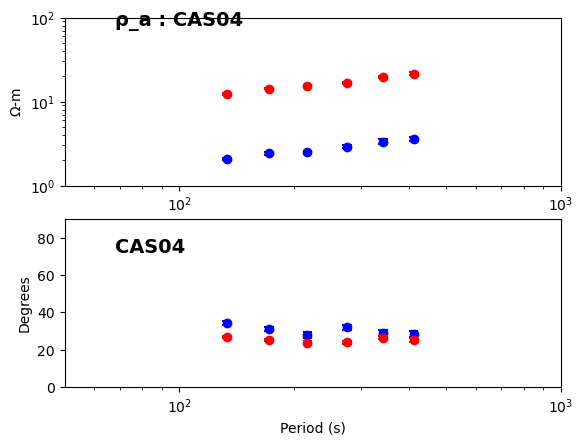

DECIMATION LEVEL 3
2023-11-15T15:36:00.185376-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
2023-11-15T15:36:00.524115-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:36:00.863002-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:36:01.187299-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:36:01.505253-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:36:01.823918-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-15T15:36:02.1324

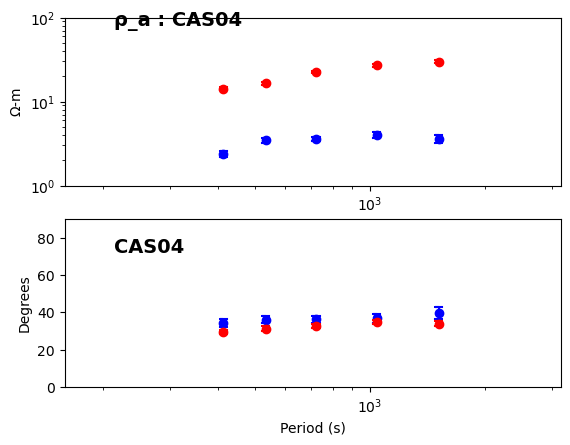

2023-11-15T15:36:03.976119-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5
2023-11-15T15:36:04.142886-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/8P_CAS04_CAV07_NVR11_REV06.h5


In [21]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )